# Notebook used to process and plot data in "Satellite Evidence of HONO/NO${_2}$ Increase with Fire Radiative Power"
## Authored by Carley Fredrickson <br>Last edited: March 28, 2023

### Import all necessary packages

In [1]:
# Packages to use Google Earth Engine
import ee
import geemap
from geemap import cartoee

# Package to work with your OS
import os

# Package to open TROPOMI .h5 files
import h5py

# Standard packages to work with data and make plots
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import path

# Packages to plot maps
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Package to use math functions and curve fitting
from math import radians, sin, cos, asin, sqrt, log10
from scipy.optimize import curve_fit

### Initialize Earth Engine

In [2]:
# You need a Google Earth Engine account to use this tool
geemap.common.ee_initialize(token_name="EARTHENGINE_TOKEN")

### Create visual parameter dictionaries for displaying Google Earth Engine images

In [3]:
vis_params_2 = {
    'bands': ['M5', 'M4', 'M3'], 
    'min': 0, 
    'max': 6000, 
    'gamma': 2,
    'alpha': 1}

vis_params_4 = {
    "bands": ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'],
    "min": 0,
    "max": 8000.0,
    "gamma": 2
}

### Navigate into the directory with TROPOMI files organized in month folders

In [ ]:
cwd = os.getcwd()
%cd ..\TROPOMI_Data\Months

### Create a function that looks for one TROPOMI file by inputted date and outputs the data into a dictionary

In [5]:
def TROPOMI_day(date_string):
    
    # Check that date_string is a valid date in our period of study
    dt_ds_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    d1 = datetime.datetime(2019, 9, 1)
    d2 = datetime.datetime(2020, 1, 31)
    
    if (dt_ds_obj < d1) or (dt_ds_obj > d2):
        print("Entered date is out of range.")
        return []
    else:
        pass
    
    # Get the current working directory
    cwd = os.getcwd()

    # Grab all the TROPOMI files and sort by date
    filenames = []
    for dirpath,dirnames,filename in os.walk(top=cwd):
        for name in filename:
            filenames.append(os.path.join(dirpath, name))
    filenames.sort()

    # Find the file that matches the date in date_string
    for file in filenames:
        split_file = file.split('.')
        get_date = split_file[0][-8:]
        get_date = '-'.join([get_date[:4], get_date[4:6], get_date[6:]])

        if get_date == date_string:
            match = 1
            break
        else:
            match = 0
            continue

    if match == 0:
        print("Entered date does not have a matching TROPOMI file.")
        return []
    else:
        pass
    
    TROPOMI_dict = {}
    
    # Create TROPOMI dictionary file
    with h5py.File(file,'r') as f:
        dset = f['Data Fields']
        h5keys = list(dset.keys())
        for key in h5keys:
            TROPOMI_dict["{:}".format(key)] = np.array(f.get('Data Fields').get(key))
    
    return TROPOMI_dict

### Creating the HONO SCD colormap

In [6]:
# Code contributed by Nicolas Theys
NT_HONO_cbar = np.genfromtxt('../../TROPOMI_Code/ColorBar_HONO.dat',
                     skip_header=0,
                     skip_footer=0,
                     names=None,
                     dtype=None,
                     delimiter='  ')

# setting up columns for list
b3=NT_HONO_cbar[:,2] # value of blue at sample n
b2=NT_HONO_cbar[:,2] # value of blue at sample n
b1=np.linspace(0,1,len(b2)) # position of sample n - ranges from 0 to 1

g3=NT_HONO_cbar[:,1]
g2=NT_HONO_cbar[:,1]
g1=np.linspace(0,1,len(g2))

r3=NT_HONO_cbar[:,0]
r2=NT_HONO_cbar[:,0]
r1=np.linspace(0,1,len(r2))

# creating list
R=zip(r1,r2,r3)
G=zip(g1,g2,g3)
B=zip(b1,b2,b3)

# transposing list
RGB=zip(R,G,B)
rgb=zip(*RGB)

# creating dictionary
k=['red', 'green', 'blue']
NT_HONO_cbar_py=dict(zip(k,rgb)) # makes a dictionary from 2 lists

my_cmap = mpl.colors.LinearSegmentedColormap('my_colormap',NT_HONO_cbar_py)

### Create a distance function, specifically the Haversine formula

In [7]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Compute difference of latitudes and longitudes
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Calculate and return the distance in kilometers (Radius of Earth is 6371 kilometers)
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

### Create a function with our figure defaults for maps

In [8]:
def figure_setup(figure_size, bbox_alt):
    # Create the figure and axis object
    fig_temp, ax_main_temp = plt.subplots(figsize=figure_size,
                                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})
    
    # Add map features, such as coastline, states, and borders
    ax_main_temp.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax_main_temp.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
    ax_main_temp.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')
    
    # Add gridlines
    gl = ax_main_temp.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    
    # Set the extent of our figure in lat/lon
    ax_main_temp.set_ylim(ymin=bbox_alt[1],ymax=bbox_alt[3])
    ax_main_temp.set_xlim(xmin=bbox_alt[0],xmax=bbox_alt[2])
    
    # Set the font size
    font_size=20
    
    return fig_temp, ax_main_temp, font_size

### Grab satellite images, TROPOMI data, and make calculations to look at a single Australian fire

In [9]:
fire_no = 4

if fire_no == 4:
    # Specify date, extent, and figure size
    day_1 = '2020-01-04'
    day_2 = '2020-01-05'
    bbox = [146.4, -39.1, 151, -34.5]
    bbox_alt = [bbox[0]-180, bbox[1], bbox[2]-180, bbox[3]]
    figure_size = (15,12)
else:
    pass

# Grab the satellite visible imagery from Suomi NPP VIIRS
sat_im = ee.ImageCollection("NOAA/VIIRS/001/VNP09GA").filter(ee.Filter.date(day_1,day_2))
sat_im_img1 = ee.Image(sat_im.first())

# Load the TROPOMI file and calculate the ratio of HONO to NO2
TROP_dict=TROPOMI_day(day_1)
TROP_dict['HONO_to_NO2'] = TROP_dict['HONO SCD']/TROP_dict['NO2 SCDcor']

# Create a boolean filter to grab TROPOMI pixels that are within the figure extent
boolean_lon = np.logical_and(TROP_dict["longitude"]>= bbox[0], TROP_dict["longitude"]<= bbox[2])
boolean_lat = np.logical_and(TROP_dict["latitude"]>= bbox[1], TROP_dict["latitude"]<= bbox[3])
boolean_latlon = np.logical_and(boolean_lon, boolean_lat)

# Grab the latitude and longitude bounds of the TROPOMI pixels
lat_bnds = TROP_dict["latitudebounds"][boolean_latlon]
lon_bnds = TROP_dict["longitudebounds"][boolean_latlon]

# Grab TROPOMI pixels where UVAI > 0 (UVAI is labeled as AAI)
boolean_AAI_pos = TROP_dict['AAI']>0

# Grab indices of pixels satisfying the location filter
ind_bool = np.where(boolean_latlon)

# Create a fine grid to capture TROPOMI pixel shape
xrange = np.arange(bbox[0], bbox[2], 0.005)
yrange = np.arange(bbox[3], bbox[1], -0.005)
xx, yy = np.meshgrid(xrange, yrange, sparse=False)
positions = np.vstack([xx.ravel(), yy.ravel()]).T

### Figure 1

C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


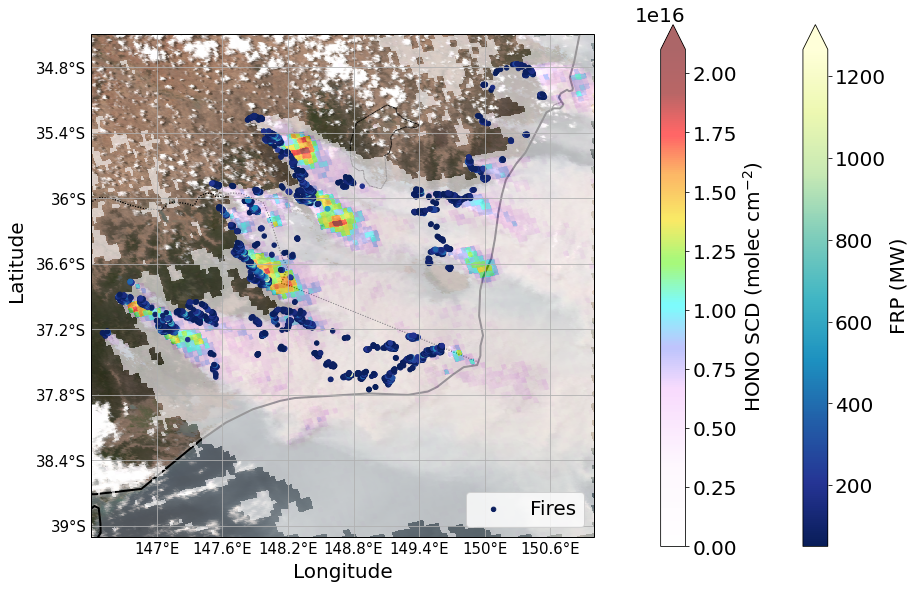

In [10]:
# Create figure 1
fig1, ax_main1, font_size = figure_setup(figure_size,bbox_alt)

# Add satellite imagery to figure 1
cartoee.add_layer(ax_main1, sat_im_img1, vis_params=vis_params_2, region=bbox)

# NASA FIRMS Map Key: Use your own
map_key = "insert_NASA_FIRMS_key_here"
    
# Grab fire locations and FRP from NASA FIRMS while also narrowing search results
start_date_str = datetime.datetime.strftime(datetime.date(int(day_1[0:4]), int(day_1[5:7]), int(day_1[8:])), "%Y-%m-%d")
firms_url = f"https://firms.modaps.eosdis.nasa.gov/usfs/api/area/csv/{map_key}/VIIRS_SNPP_SP/100,-50,180,0/1/{start_date_str}"
firms = pd.read_csv(firms_url)
firms_frp = firms[["latitude", "longitude", "acq_date", "confidence", "frp", "daynight", "type"]]
firms_frp = firms_frp[(firms_frp["daynight"] == "D") & # day fires
                      (firms_frp["type"] == 0) & # 0 = presumed vegetation fire
                      ((firms_frp["confidence"] == "n") | (firms_frp["confidence"] == "h")) & # nominal and high (saturated)
                      (firms_frp["frp"] > 50)] # 50 MW
firms_frp.drop(columns=["daynight", "type"])

# Plot the Fire FRPS
plt.sca(ax_main1)
plz2 = plt.scatter(firms_frp['longitude'],
                   firms_frp['latitude'],
                   s=20,
                   c=firms_frp['frp'],
                   transform=ccrs.PlateCarree(),
                   alpha=1,
                   label='Fires',
                   cmap='YlGnBu_r',
                   zorder=2)

# Create and specify the colorbar
cbar2 = plt.colorbar(shrink=0.8,pad=0.05, extend='max')
cbar2.ax.tick_params(labelsize=font_size)
cbar2.ax.yaxis.offsetText.set(size=20)
cbar2.set_label(label='FRP (MW)', fontsize=font_size)

# Reformat TROPOMI dictionary and boolean variables
HONO_TROP = np.squeeze(np.reshape(TROP_dict["HONO SCD"][ind_bool],(1,-1)))
bool_AAI_pos_sqz = np.squeeze(np.reshape(boolean_AAI_pos[ind_bool],(1,-1)))

gHONO_TROP = np.zeros(np.size(xx)) # g(rid) HONO_TROP
gboolAAIpos = np.zeros(np.size(xx)) # g(rid) bool_AAI_pos_sqz

# Input the spatially larger TROPOMI pixel values into the fine grid pixels
for i in np.arange(0,np.size(HONO_TROP)):
    p = path.Path([(lon_bnds[i][0],lat_bnds[i][0]), 
                   (lon_bnds[i][1],lat_bnds[i][1]), 
                   (lon_bnds[i][2],lat_bnds[i][2]), 
                   (lon_bnds[i][3],lat_bnds[i][3])])
    bool_g = p.contains_points(positions)
    gHONO_TROP[bool_g] = HONO_TROP[i]
    gboolAAIpos[bool_g] = bool_AAI_pos_sqz[i]

# Reshape arrays
gHONO_TROP = np.reshape(gHONO_TROP,np.shape(xx))
gboolAAIpos = np.reshape(gboolAAIpos,np.shape(xx))

# Create a masked array to show only TROPOMI pixels where UVAI > 0
gHONO_TROP_mask = np.ma.array(gHONO_TROP)
gHONO_TROP_masked = np.ma.masked_where(gboolAAIpos==False, gHONO_TROP_mask)

# Plot the TROPOMI pixels on the fine grid
plt.sca(ax_main1)
plz1 = plt.imshow(gHONO_TROP_masked, 
                  transform=ccrs.PlateCarree(), 
                  extent=(bbox[0],bbox[2],bbox[1],bbox[3]), 
                  origin='upper', 
                  cmap=my_cmap,
                  vmin=0, 
                  vmax=np.ma.max(gHONO_TROP_masked),
                  alpha=0.6,
                  zorder=1
                 )
# Add the x and y labels
ax_main1.text(-0.13, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax_main1.transAxes, fontsize=font_size)
ax_main1.text(0.5, -0.09, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax_main1.transAxes, fontsize = font_size)

# Create and specify the colorbar
cbar1 = plt.colorbar(shrink=0.8,pad=0.1, extend='max')
cbar1.ax.tick_params(labelsize=font_size)
cbar1.ax.yaxis.offsetText.set(size=20)
cbar1.set_label(label='HONO SCD (molec cm$^{-2}$)', fontsize=font_size)

# Add legend
legend1 = ax_main1.legend(loc='lower right', fontsize=20)

# Uncomment below if you want to save figure
#plt.savefig(f'fig1.png', dpi=300)

### Figure 2 Plots

#### Figure 2a. Australia Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

[0.00102451 0.13160725]
[0.00023498 0.03885865]
0.9745580796107911


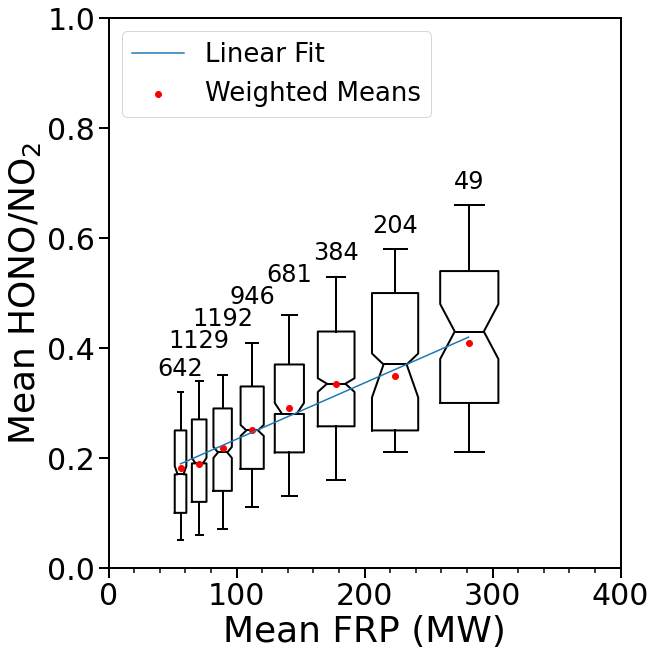

In [11]:
# Load processed file and only look at data more south than -10.58 S
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_2_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df = frp_rhn_df[frp_rhn_df['TROP Latitude']<-10.58]
frp_rhn_df.dropna(inplace=True)

# Create figure
fig, axs = plt.subplots(figsize=(9,9), constrained_layout=True)

ind_limiter = 16 # Variable for plotting boxplots

# Create temp variable to make length of code per line shorter, creates bin edges
temp_bin_pos = np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"])))+0.1,0.1)

# Assign each Mean FRP value a bin number
ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][:]),temp_bin_pos)

# Create arrays for the boxplot function split into bin number
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"][:])))+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][:][ind_dbins==num]
    boxplot_error[f"{num}"] = frp_rhn_df["Error Area RHN"][:][ind_dbins==num]

# Remove boxplot bins that have less than 30 counts
hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

# Specify and calculate boxplot bin width in plot
w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

# Values and error values of points found in each bin
temp_slim = [slim[1] for slim in list(boxplot_array.items())]
temp_tlim = [tlim[1] for tlim in list(boxplot_error.items())]

# Code to distinguish where to plot boxplots on x-axis
pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
pos_post = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
if temp_slim[ind_limiter-1].empty:
    pos_used = pos_pre
else:
    pos_used = pos_post

# Create the boxplots
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=pos_used,
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.06, 0.09, 0.07,
         0.06, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03] # need jumps for numbers that get in the way
noofobs = [temp_slim[i].count() for i in np.arange(0,21)]
caps = test_stop['caps'] # the caps of the boxplots
whisk = test_stop['whiskers'] # the whickers of the boxplots
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps, x positions of the whiskers
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number in each boxplot
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=24)

# Calculate the weighted means, the standard errors, and standard deviations of each boxplot
av_means = []
av_stdevs = []
av_sterr = []
for ind in np.arange(0,len(temp_slim)):
    if temp_tlim[ind].empty:
        av_means.append(None)
        av_stdevs.append(None)
        av_sterr.append(None)
    else:
        av_means.append(np.average(temp_slim[ind], weights=1/(temp_tlim[ind]**2)))
        av_sterr.append(np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        av_stdevs.append(np.sqrt(temp_slim[ind].count())*np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))

# Make lists into numpy arrays
av_sterr = np.asarray([av_sterr[i] for (i, v) in enumerate(av_means) if v != None])
av_stdevs = np.asarray([av_stdevs[i] for (i, v) in enumerate(av_means) if v != None])
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

# Specify axis parameters
axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,400))
plt.xticks(np.arange(0, 500, step=100),['0','100','200','300','400'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 36)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 36)
axs.tick_params(axis='y', labelsize= 30)
axs.tick_params(axis='x', labelsize= 30)
t = axs.yaxis.get_offset_text()
t.set_size(30)
axs.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1.5, which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)

# Code to plot each boxplot's weighted means (red dots)
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    x_used = old_x
else:
    x_used = new_x
axs.scatter(x = x_used, y = av_means, c='red', label='Weighted Means',zorder=3)


# Code to add linear fit of the weighted means
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],
                     np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, 
                       xfit, 
                       av_means_short, 
                       sigma=av_stdevs, 
                       absolute_sigma=True, 
                       p0=[1,0], 
                       maxfev=5000)

# Plot the linear fit and add the legend
axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit',zorder=3)
axs.legend(fontsize=26, loc='upper left')

# Print the linear coefficients
print(popt)
# Print the one standard deviation errors of the linear coefficients
perr = np.sqrt(np.diag(pcov))
print(perr)
# Print the R^2 of the linear fit
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figure
#plt.savefig(f'fig2a.svg')
#plt.savefig(f'fig2a.png', dpi=300)

#### Figure 2b. Australia Mean HONO SCD vs Mean FRP: Binned boxplots

[1.53215087e+13 3.81949502e+14]
[1.42270504e+12 2.23483795e+14]
0.9816869514940445


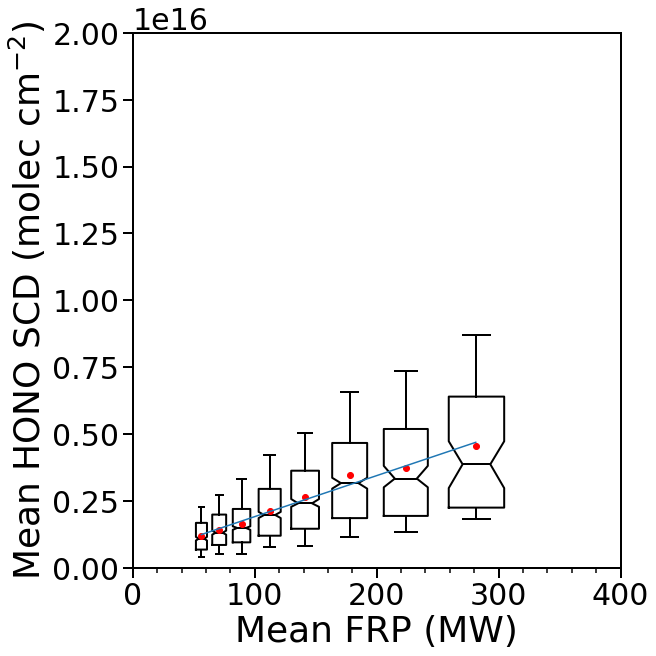

In [12]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_2_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df = frp_rhn_df[frp_rhn_df['TROP Latitude']<-10.58]
frp_rhn_df.dropna(inplace=True)

fig, axs = plt.subplots(figsize=(9,9), constrained_layout=True)

ind_limiter = 16 

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"])))+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][:]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"][:])))+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean HONO"][:][ind_dbins==num]
    boxplot_error[f"{num}"] = frp_rhn_df["Error Area HONO"][:][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

temp_slim = [slim[1] for slim in list(boxplot_array.items())]
temp_tlim = [tlim[1] for tlim in list(boxplot_error.items())]

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
pos_post = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))

if temp_slim[ind_limiter-1].empty:
    pos_used = pos_pre
else:
    pos_used = pos_post

test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=pos_used,
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

av_means = []
av_stdevs = []
av_sterr = []
for ind in np.arange(0,len(temp_slim)):
    if temp_tlim[ind].empty:
        av_means.append(None)
        av_stdevs.append(None)
        av_sterr.append(None)
    else:
        av_means.append(np.average(temp_slim[ind], weights=1/(temp_tlim[ind]**2)))
        av_sterr.append(np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        av_stdevs.append(np.sqrt(temp_slim[ind].count())*np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        
av_sterr = np.asarray([av_sterr[i] for (i, v) in enumerate(av_means) if v != None])
av_stdevs = np.asarray([av_stdevs[i] for (i, v) in enumerate(av_means) if v != None])
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])


axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,400))
plt.xticks(np.arange(0, 500, step=100),['0','100','200','300','400'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0*10**16,2.0*10**16))
axs.set_xlabel("Mean FRP (MW)", fontsize = 36)
axs.set_ylabel("Mean HONO SCD (molec cm${^{-2}}$)", fontsize = 36)
axs.tick_params(axis='y', labelsize= 30)
axs.tick_params(axis='x', labelsize= 30)
t = axs.yaxis.get_offset_text()
t.set_size(30)
axs.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1.5, which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    x_used = old_x
else:
    x_used = new_x
axs.scatter(x = x_used, y = av_means, c='red', label='Weighted Means',zorder=3)

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],
                     np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, 
                       xfit, 
                       av_means_short, 
                       sigma=av_stdevs, 
                       absolute_sigma=True, 
                       p0=[9.357e+15,9.357e+15], 
                       maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit',zorder=3)

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figures
#plt.savefig(f'fig2b.svg')
#plt.savefig(f'fig2b.png', dpi=300)

#### Figure 2c. Australia Mean NO${_2}$ SCD vs Mean FRP: Binned boxplots

[1.75884614e+13 4.16451557e+15]
[3.57577341e+12 5.61827186e+14]
0.8119720391281633
[2.59144060e+15 1.05643327e-01]
[4.91665497e+14 5.22543849e-02]
0.9391307782139202
[8.60328019e+15 9.09049815e+15 1.35766201e-02]
[9.33048514e+14 3.54581946e+15 8.16585211e-03]
0.9782932464804468


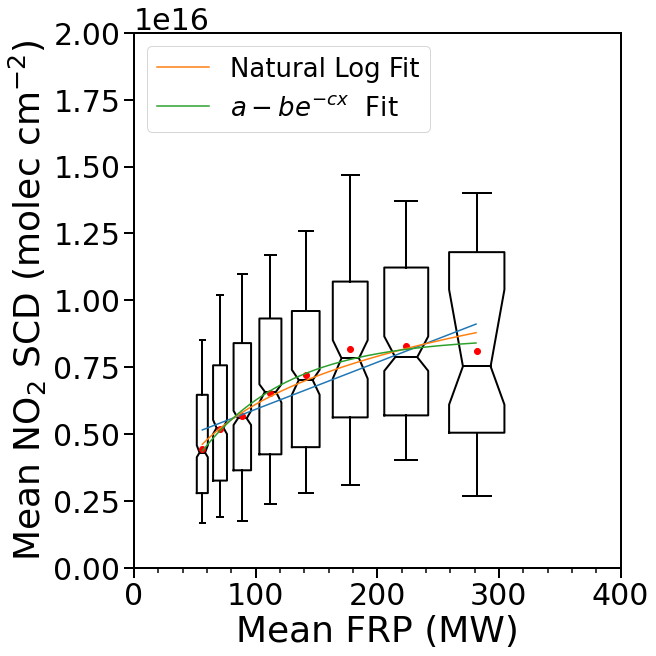

In [13]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_2_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df = frp_rhn_df[frp_rhn_df['TROP Latitude']<-10.58]
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9,9), constrained_layout=True)

ind_limiter = 16

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"])))+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][:]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"][:])))+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean NO2cor"][:][ind_dbins==num]
    boxplot_error[f"{num}"] = frp_rhn_df["Error Area NO2cor"][:][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

temp_slim = [slim[1] for slim in list(boxplot_array.items())]
temp_tlim = [tlim[1] for tlim in list(boxplot_error.items())]

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
pos_post = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))

if temp_slim[ind_limiter-1].empty:
    pos_used = pos_pre
else:
    pos_used = pos_post

test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=pos_used,
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w), 
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)


av_means = []
av_stdevs = []
av_sterr = []
for ind in np.arange(0,len(temp_slim)):
    if temp_tlim[ind].empty:
        av_means.append(None)
        av_stdevs.append(None)
        av_sterr.append(None)
    else:
        av_means.append(np.average(temp_slim[ind], weights=1/(temp_tlim[ind]**2)))
        av_sterr.append(np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        av_stdevs.append(np.sqrt(temp_slim[ind].count())*np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        
av_sterr = np.asarray([av_sterr[i] for (i, v) in enumerate(av_means) if v != None])
av_stdevs = np.asarray([av_stdevs[i] for (i, v) in enumerate(av_means) if v != None])
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,400))
plt.xticks(np.arange(0, 500, step=100),['0','100','200','300','400'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0*10**16,2.0*10**16))
axs.set_xlabel("Mean FRP (MW)", fontsize = 36)
axs.set_ylabel("Mean NO${_2}$ SCD (molec cm${^{-2}}$)", fontsize = 36)
axs.tick_params(axis='y', labelsize= 30)
axs.tick_params(axis='x', labelsize= 30)
t = axs.yaxis.get_offset_text()
t.set_size(30)
axs.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1.5, which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    x_used = old_x
else:
    x_used = new_x
axs.scatter(x = x_used, y = av_means, c='red',zorder=3)

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, 
                       xfit, 
                       av_means_short, 
                       sigma=av_stdevs, 
                       absolute_sigma=True, 
                       p0=[9.357e+15,9.357e+15], 
                       maxfev=5000)


axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-',zorder=3)

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

## Fit #2
def func2(x, a, b):
    return a * np.log(b*x)
popt2, pcov2 = curve_fit(func2, 
                         xfit, 
                         av_means_short, 
                         sigma=av_stdevs, 
                         absolute_sigma=True, 
                         p0=[8e+15,1], 
                         maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), 
         func2(np.arange(xfit[0],xfit[-1],1), *popt2),
         '-', 
         label='Natural Log Fit',
         zorder=3)

print(popt2)
perr2 = np.sqrt(np.diag(pcov2))
print(perr2)
residuals2 = av_means_short - func2(xfit, *popt2)
ss_res2 = np.sum(residuals2**2)
ss_tot2 = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared2 = 1 - (ss_res2 / ss_tot2)
print(r_squared2)

## Fit #3
def func3(x, a, b, c):
    return a - b*np.exp(-c*x)
popt3, pcov3 = curve_fit(func3, 
                         xfit, 
                         av_means_short, 
                         sigma=av_stdevs, 
                         absolute_sigma=True, 
                         p0=[8e+15,6e+15,0.02], 
                         maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), 
         func3(np.arange(xfit[0],xfit[-1],1), *popt3),
         '-', 
         label='$a-be^{-cx}$  Fit',
         zorder=3)
axs.legend(fontsize=26, loc='upper left')

print(popt3)
perr3 = np.sqrt(np.diag(pcov3))
print(perr3)
residuals3 = av_means_short - func3(xfit, *popt3)
ss_res3 = np.sum(residuals3**2)
ss_tot3 = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared3 = 1 - (ss_res3 / ss_tot3)
print(r_squared3)

# Uncomment to save figures
#plt.savefig(f'fig2c.svg')
#plt.savefig(f'fig2c.png', dpi=300)

#### Figure 2d. Grassland and savanna Australia Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

[0.00109478 0.08120072]
[0.00033921 0.04808798]
0.9892448682342714


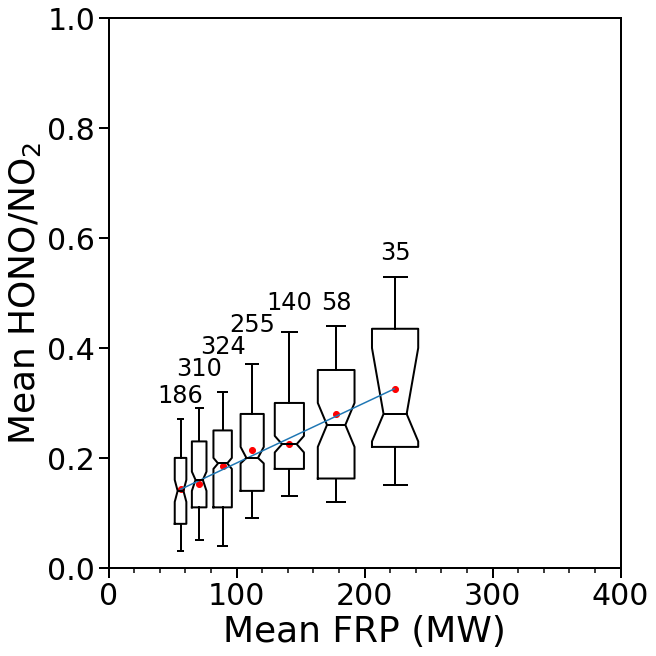

In [14]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_2_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df = frp_rhn_df[frp_rhn_df['TROP Latitude']<-10.58]
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

ind_limiter = 16

# Select for grassland and savanna types
sel_combo = ((frp_rhn_df["LC Type 1"]==9)|(frp_rhn_df["LC Type 1"]==10))

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"][sel_combo])))+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][sel_combo]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"][sel_combo])))+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][sel_combo][ind_dbins==num]
    boxplot_error[f"{num}"] = frp_rhn_df["Error Area RHN"][sel_combo][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

temp_slim = [slim[1] for slim in list(boxplot_array.items())]
temp_tlim = [tlim[1] for tlim in list(boxplot_error.items())]

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
pos_post = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))

if temp_slim[ind_limiter-1].empty:
    pos_used = pos_pre
else:
    pos_used = pos_post
    
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=pos_used,
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.06, 0.07, 0.06,
         0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,len(temp_slim))]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number in boxplots
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=24)

av_means = []
av_stdevs = []
av_sterr = []
for ind in np.arange(0,len(temp_slim)):
    if temp_tlim[ind].empty:
        av_means.append(None)
        av_stdevs.append(None)
        av_sterr.append(None)
    else:
        av_means.append(np.average(temp_slim[ind], weights=1/(temp_tlim[ind]**2)))
        av_sterr.append(np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        av_stdevs.append(np.sqrt(temp_slim[ind].count())*np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        
av_sterr = np.asarray([av_sterr[i] for (i, v) in enumerate(av_means) if v != None])
av_stdevs = np.asarray([av_stdevs[i] for (i, v) in enumerate(av_means) if v != None])
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((10,10**(np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"]))))))
axs.set_xlim((0,400))
plt.xticks(np.arange(0, 500, step=100),['0','100','200','300','400'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 36)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 36)
axs.tick_params(axis='y', labelsize= 30)
axs.tick_params(axis='x', labelsize= 30)
t = axs.yaxis.get_offset_text()
t.set_size(30)
axs.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1.5, which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
axs.scatter(x = new_x, y = av_means, c='red', label='Weighted Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, 
                       xfit, 
                       av_means_short, 
                       sigma=av_stdevs, 
                       absolute_sigma=True, 
                       p0=[1,0], 
                       maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)


# Uncomment to save figures
#plt.savefig(f'fig2d.svg')
#plt.savefig(f'fig2d.png', dpi=300)

#### Figure 2e. Shrubland Australia Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

[0.0003217  0.10790115]
[0.00035591 0.04410218]
0.7645624890401694


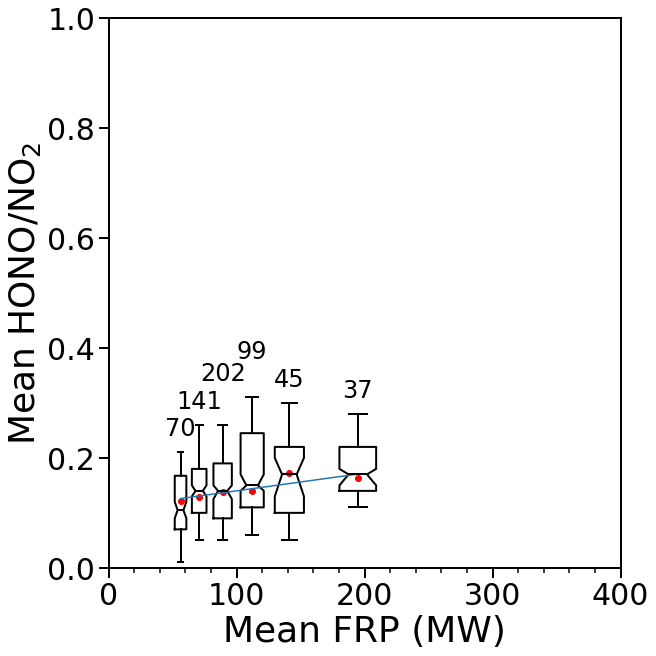

In [15]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_2_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df = frp_rhn_df[frp_rhn_df['TROP Latitude']<-10.58]
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

limiter = 2.1
ind_limiter = 13

# Select for shrubland land cover types
sel_combo = ((frp_rhn_df["LC Type 1"]==6)|(frp_rhn_df["LC Type 1"]==7))

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,limiter+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][sel_combo]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,limiter+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][sel_combo][ind_dbins==num] 
    boxplot_error[f"{num}"] = frp_rhn_df["Error Area RHN"][sel_combo][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

temp_slim = [slim[1] for slim in list(boxplot_array.items())]
temp_tlim = [tlim[1] for tlim in list(boxplot_error.items())]

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
pos_post = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))

if temp_slim[ind_limiter-1].empty:
    pos_used = pos_pre
else:
    pos_used = pos_post
    
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=pos_used,
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.08, 0.07,
         0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,13)]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number of fliers
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=24)

av_means = []
av_stdevs = []
av_sterr = []
for ind in np.arange(0,len(temp_slim)):
    if temp_tlim[ind].empty:
        av_means.append(None)
        av_stdevs.append(None)
        av_sterr.append(None)
    else:
        av_means.append(np.average(temp_slim[ind], weights=1/(temp_tlim[ind]**2)))
        av_sterr.append(np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        av_stdevs.append(np.sqrt(temp_slim[ind].count())*np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        
av_sterr = np.asarray([av_sterr[i] for (i, v) in enumerate(av_means) if v != None])
av_stdevs = np.asarray([av_stdevs[i] for (i, v) in enumerate(av_means) if v != None])
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((10,10**(np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"]))))))
axs.set_xlim((0,400))
plt.xticks(np.arange(0, 500, step=100),['0','100','200','300','400'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 36)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 36)
axs.tick_params(axis='y', labelsize= 30)
axs.tick_params(axis='x', labelsize= 30)
t = axs.yaxis.get_offset_text()
t.set_size(30)
axs.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1.5, which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
axs.scatter(x = new_x, y = av_means, c='red', label='Weighted Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, 
                       xfit, 
                       av_means_short, 
                       sigma=av_stdevs, 
                       absolute_sigma=True, 
                       p0=[1,0], 
                       maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment to save figures
#plt.savefig(f'fig2e.svg')
#plt.savefig(f'fig2e.png', dpi=300)

#### Figure 2f. Evergreen Australia Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

[0.00083031 0.19765178]
[0.00022038 0.03764418]
0.9361118539631874


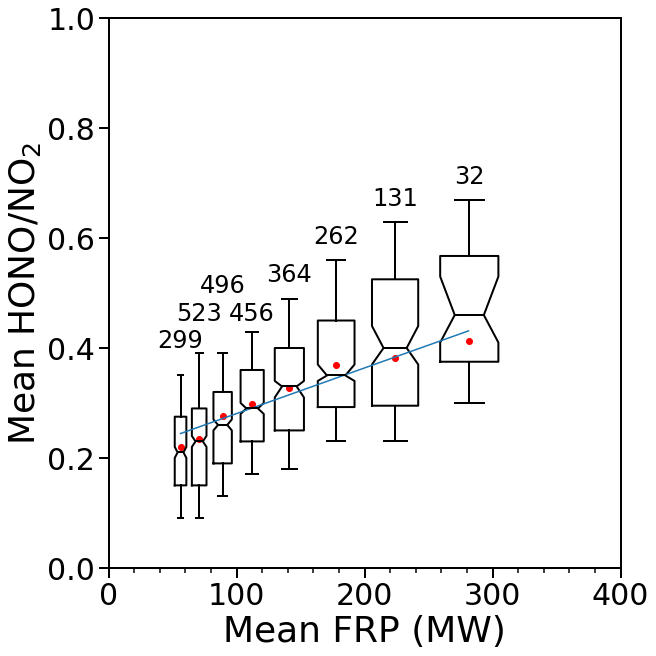

In [16]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_2_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df = frp_rhn_df[frp_rhn_df['TROP Latitude']<-10.58]
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

limiter = 2.5
ind_limiter = 16

# Select for evergreen land cover types
sel_combo = ((frp_rhn_df["LC Type 1"]==1)|(frp_rhn_df["LC Type 1"]==2))

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,limiter+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][sel_combo]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,limiter+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][sel_combo][ind_dbins==num]
    boxplot_error[f"{num}"] = frp_rhn_df["Error Area RHN"][sel_combo][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

temp_slim = [slim[1] for slim in list(boxplot_array.items())]
temp_tlim = [tlim[1] for tlim in list(boxplot_error.items())]

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
pos_post = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))

if temp_slim[ind_limiter-1].empty:
    pos_used = pos_pre
else:
    pos_used = pos_post
    
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=pos_used,
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.05, 0.06, 0.11, 0.02,
         0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,len(temp_slim))]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number of fliers
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=24)

av_means = []
av_stdevs = []
av_sterr = []
for ind in np.arange(0,len(temp_slim)):
    if temp_tlim[ind].empty:
        av_means.append(None)
        av_stdevs.append(None)
        av_sterr.append(None)
    else:
        av_means.append(np.average(temp_slim[ind], weights=1/(temp_tlim[ind]**2)))
        av_sterr.append(np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        av_stdevs.append(np.sqrt(temp_slim[ind].count())*np.sqrt(1/np.nansum((1/(temp_tlim[ind]**2)))))
        
av_sterr = np.asarray([av_sterr[i] for (i, v) in enumerate(av_means) if v != None])
av_stdevs = np.asarray([av_stdevs[i] for (i, v) in enumerate(av_means) if v != None])
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((10,10**(np.ceil(np.nanmax(np.log10(frp_rhn_df["Mean FRP"]))))))
axs.set_xlim((0,400))
plt.xticks(np.arange(0, 500, step=100),['0','100','200','300','400'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 36)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 36)
axs.tick_params(axis='y', labelsize= 30)
axs.tick_params(axis='x', labelsize= 30)
t = axs.yaxis.get_offset_text()
t.set_size(30)
axs.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
axs.tick_params('both', length=10, width=2, which='major')
axs.tick_params('both', length=5, width=1.5, which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2)

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
axs.scatter(x = new_x, y = av_means, c='red', label='Weighted Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, xfit, av_means_short, sigma=av_stdevs, absolute_sigma=True, p0=[1,0], maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figures
#plt.savefig(f'fig2f.svg')
#plt.savefig(f'fig2f.png', dpi=300)

### Figure 3 Plots

#### Figure 3a. Global Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

[0.00057027 0.31157833]
[7.78140641e-05 1.92573653e-02]
0.8703586028556545


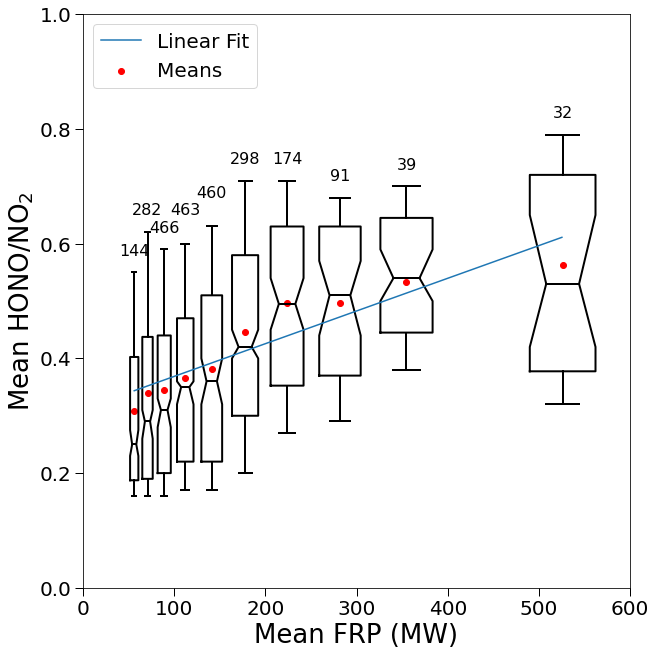

In [17]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_3_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

limiter = 2.6
ind_limiter = 17

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,limiter+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][:]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,limiter+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][:][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')
        boxplot_error[f"{item}"]=pd.Series([],dtype='float64')

w = 0.07 
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter])),
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

temp_slim = [slim[1] for slim in list(boxplot_array.items())]

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.05,
         0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,len(temp_slim))]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number of fliers
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=16)

av_means = []
for ind in np.arange(0,len(temp_slim)):
    if temp_slim[ind].empty:
        av_means.append(None)
    else:
        av_means.append(np.average(temp_slim[ind]))
        
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,600))
plt.xticks(np.arange(0, 700, step=100),['0','100','200','300','400','500','600'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 26)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 26)
axs.tick_params(axis='y', labelsize= 20)
axs.tick_params(axis='x', labelsize= 20)
t = axs.yaxis.get_offset_text()
t.set_size(20)
axs.tick_params('both', length=8, width=1, which='major')
axs.tick_params('both', length=4, width=0.5, which='minor')

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
axs.scatter(x = new_x, y = av_means, c='red', label='Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][:][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, xfit, av_means_short, p0=[1,0], maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')
axs.legend(fontsize=20, loc='upper left')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figures
#plt.savefig(f'fig3a.svg')
#plt.savefig(f'fig3a.png', dpi=300)

#### Figure 3b. Grassland and savanna Global Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.00109138 0.22494166]
[0.00013995 0.02266537]
0.91019984139082


C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


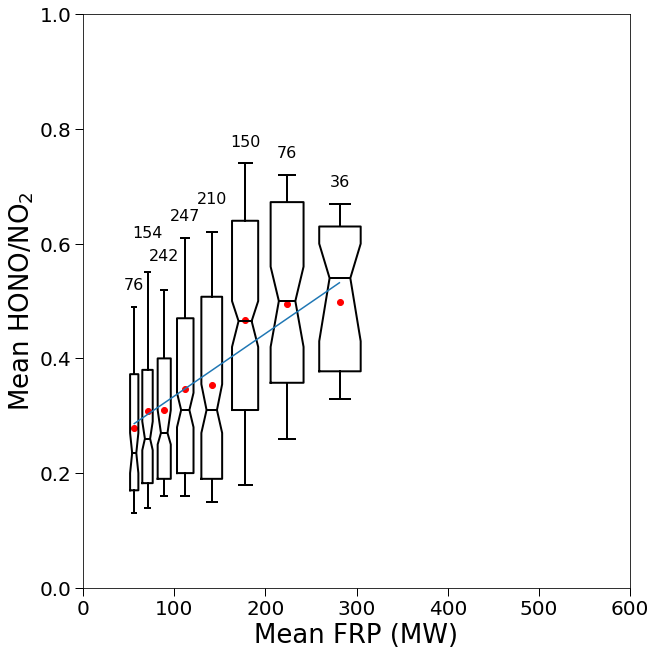

In [18]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_3_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

limiter = 3.1
ind_limiter = 22

# Select for grassland and savanna land cover types
sel_combo = ((frp_rhn_df["LC Type 1"]==9)|(frp_rhn_df["LC Type 1"]==10))

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,limiter+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][sel_combo]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,limiter+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][sel_combo][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter])), 
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

temp_slim = [slim[1] for slim in list(boxplot_array.items())]

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.06, 0.05, 0.03,
         0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,len(temp_slim))]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number of fliers
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=16)

av_means = []
for ind in np.arange(0,len(temp_slim)):
    if temp_slim[ind].empty:
        av_means.append(None)
    else:
        av_means.append(np.average(temp_slim[ind]))
        
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,600))
plt.xticks(np.arange(0, 700, step=100),['0','100','200','300','400','500','600'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 26)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 26)
axs.tick_params(axis='y', labelsize= 20)
axs.tick_params(axis='x', labelsize= 20)
t = axs.yaxis.get_offset_text()
t.set_size(20)
axs.tick_params('both', length=8, width=1, which='major')
axs.tick_params('both', length=4, width=0.5, which='minor')

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    x_add = old_x
else:
    x_add = new_x
axs.scatter(x = x_add, y = av_means, c='red', label='Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, xfit, av_means_short, p0=[1,0], maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figures
#plt.savefig(f'fig3b.svg')
#plt.savefig(f'fig3b.png', dpi=300)

#### Figure 3c. Shrubland Global Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.00094386 0.19853201]
[0.00023965 0.03375482]
0.9394393908601743


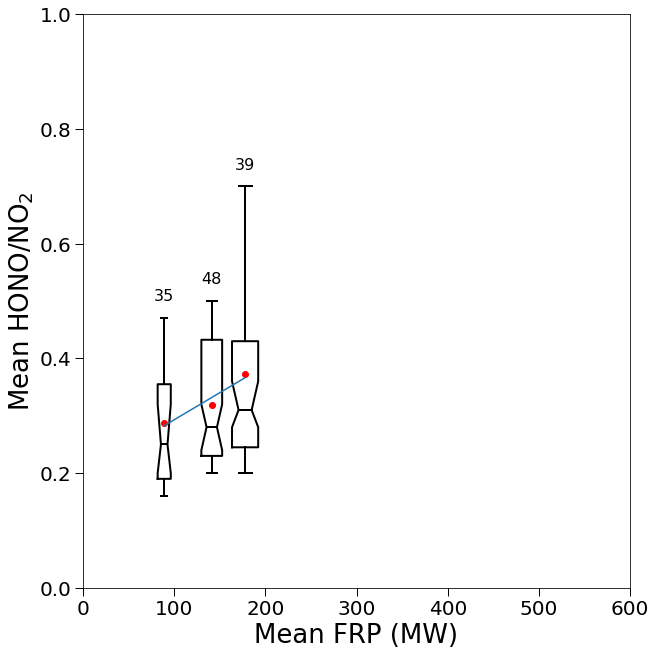

In [19]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_3_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

limiter = 3.1
ind_limiter = 22

# Select for shrubland land cover types
sel_combo = ((frp_rhn_df["LC Type 1"]==6)|(frp_rhn_df["LC Type 1"]==7))


# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,limiter+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][sel_combo]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,limiter+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][sel_combo][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter])),
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

temp_slim = [slim[1] for slim in list(boxplot_array.items())]

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
         0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,len(temp_slim))]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number of fliers
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=16)

av_means = []
for ind in np.arange(0,len(temp_slim)):
    if temp_slim[ind].empty:
        av_means.append(None)
    else:
        av_means.append(np.average(temp_slim[ind]))
        
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,600))
plt.xticks(np.arange(0, 700, step=100),['0','100','200','300','400','500','600'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 26)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 26)
axs.tick_params(axis='y', labelsize= 20)
axs.tick_params(axis='x', labelsize= 20)
t = axs.yaxis.get_offset_text()
t.set_size(20)
axs.tick_params('both', length=8, width=1, which='major')
axs.tick_params('both', length=4, width=0.5, which='minor')

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    x_add = old_x
else:
    x_add = new_x
axs.scatter(x = x_add, y = av_means, c='red', label='Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, xfit, av_means_short, p0=[1,0], maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figures
#plt.savefig(f'fig3c.svg')
#plt.savefig(f'fig3c.png', dpi=300)

#### Figure 3d. Evergreen Global Mean HONO/NO${_2}$ vs Mean FRP: Binned boxplots

C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\fredr\.conda\envs\TROPOMI\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.00084916 0.35609969]
[0.00022578 0.03122281]
0.8250187466421841


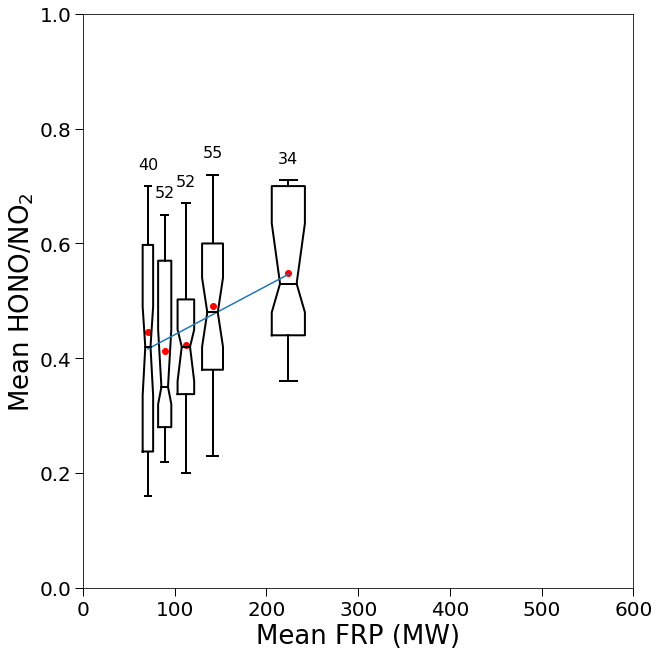

In [20]:
frp_rhn_df = pd.read_csv('../FRP Tables/Data_supporting_figure_3_satellite_evidence_of_HONO_NO2_increase_with_fire_radiative_power.csv',index_col=0)
frp_rhn_df.dropna(inplace=True)

# Format the figure space and shape
fig, axs = plt.subplots(figsize=(9, 9), constrained_layout=True)

limiter = 2.8
ind_limiter = 19

# Select for evergreen land cover types
sel_combo = ((frp_rhn_df["LC Type 1"]==1)|(frp_rhn_df["LC Type 1"]==2))

# Create temp variables to make length of code per line shorter
temp_bin_pos = np.arange(1,limiter+0.1,0.1)

ind_dbins = np.digitize(np.log10(frp_rhn_df["Mean FRP"][sel_combo]),temp_bin_pos)
boxplot_array ={}
boxplot_error ={}
for num in np.arange(1,np.size(np.arange(1,limiter+0.1,0.1))+1):
    boxplot_array[f"{num}"] = frp_rhn_df["Mean RHN"][sel_combo][ind_dbins==num]

hist_prep = pd.Series(ind_dbins)
for item in hist_prep.sort_values().unique():
    if hist_prep[hist_prep==item].count()<30:
        hist_prep=hist_prep[hist_prep!=item]
        boxplot_array[f"{item}"]=pd.Series([],dtype='float64')

w = 0.07
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos_pre = 10**((np.round(temp_bin_pos*10)/10)+0.05)
test_stop = axs.boxplot([slim[1] for slim in list(boxplot_array.items())],
            positions=np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter])),
            widths=width(10**((np.round(temp_bin_pos*10)/10)+0.05),w),
            whis = (10,90),
            bootstrap = 5000,
            showfliers = False,
            medianprops={"color": "black", "linewidth": 2},
            boxprops={"linewidth": 2},
            whiskerprops={ "linewidth": 2},
            capprops={ "linewidth": 2},
            meanprops={"marker": "o","markerfacecolor": "red", "markeredgecolor":"red", "markersize": 7},
            notch=True)

temp_slim = [slim[1] for slim in list(boxplot_array.items())]

# Add number text above boxplots
jumps = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
         0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
noofobs = [temp_slim[i].count() for i in np.arange(0,len(temp_slim))]
# the caps from the dictionary
caps = test_stop['caps']
whisk = test_stop['whiskers']
# loop over boxes in x direction
for j in range(1,len(caps)+1,2):
    # the y and x positions of the caps
    ycaps = caps[j].get_ydata()
    xcaps = caps[j].get_xdata()
    xwhisk = whisk[j].get_xdata()
    if np.isnan(ycaps).any():
        continue
    else:
        pass
    # the unique locations of caps in y 
    ucaps = set(ycaps)
    uwhisk = set(xwhisk)
    # loop over unique caps
    for i, uf in enumerate(ucaps):
        # print number of fliers
        axs.text(xwhisk[i], uf + jumps[(j-1)//2], noofobs[(j-1)//2], ha='center', fontsize=16)


av_means = []
for ind in np.arange(0,len(temp_slim)):
    if temp_slim[ind].empty:
        av_means.append(None)
    else:
        av_means.append(np.average(temp_slim[ind]))
        
temp_bin_pos_short = np.asarray([temp_bin_pos[i] for (i, v) in enumerate(av_means) if v != None])
av_means_short = np.asarray([av_means[i] for (i, v) in enumerate(av_means) if v != None])

axs.tick_params(axis='x', pad=4) 
axs.set_xlim((0,600))
plt.xticks(np.arange(0, 700, step=100),['0','100','200','300','400','500','600'])  # Set label locations for linear xaxis Mean FRP
axs.set_ylim((0,1))
axs.set_xlabel("Mean FRP (MW)", fontsize = 26)
axs.set_ylabel("Mean HONO/NO${_2}$", fontsize = 26)
axs.tick_params(axis='y', labelsize= 20)
axs.tick_params(axis='x', labelsize= 20)
t = axs.yaxis.get_offset_text()
t.set_size(20)
axs.tick_params('both', length=8, width=1, which='major')
axs.tick_params('both', length=4, width=0.5, which='minor')

# Code to add weighted means (red dots) and uncertainty
new_x = np.append(pos_pre[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_x = 10**((np.round(temp_bin_pos*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    x_add = old_x
else:
    x_add = new_x
axs.scatter(x = x_add, y = av_means, c='red', label='Means')

# Code to add linear fit of the means
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
new_xfit = np.append((10**((np.round(temp_bin_pos_short*10)/10)+0.05))[:-1],np.average(frp_rhn_df["Mean FRP"][sel_combo][ind_dbins==ind_limiter]))
old_xfit = 10**((np.round(temp_bin_pos_short*10)/10)+0.05)
if temp_slim[ind_limiter-1].empty:
    xfit = old_xfit
else:
    xfit = new_xfit
popt, pcov = curve_fit(func, xfit, av_means_short, p0=[1,0], maxfev=5000)

axs.plot(np.arange(xfit[0],xfit[-1],1), func(np.arange(xfit[0],xfit[-1],1), *popt), '-', label='Linear Fit')

print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
residuals = av_means_short - func(xfit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((av_means_short-np.mean(av_means_short))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

# Uncomment below to save figures
plt.savefig(f'fig3d.svg')
plt.savefig(f'fig3d.png', dpi=300)